In [ ]:
from google.colab import files
uploaded = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Try importing NLTK and WordCloud - with fallbacks if they're not available
try:
    import nltk
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer, WordNetLemmatizer
    from nltk.tokenize import word_tokenize
    nltk_available = True
except ImportError:
    print("NLTK is not available. Using simplified text processing...")
    nltk_available = False

try:
    from wordcloud import WordCloud
    wordcloud_available = True
except ImportError:
    print("WordCloud is not available. Skipping word cloud visualizations...")
    wordcloud_available = False

In [ ]:
# Download necessary NLTK resources
try:
    # Try downloading with explicit download directory
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    print("NLTK resources downloaded successfully!")
except Exception as e:
    print(f"Error downloading NLTK resources: {e}")
    print("Attempting alternate download method...")
    # Alternative download method with error handling
    import ssl
    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

    try:
        nltk.download('punkt', quiet=True)
        nltk.download('stopwords', quiet=True)
        nltk.download('wordnet', quiet=True)
        print("NLTK resources downloaded successfully with alternate method!")
    except Exception as e:
        print(f"Still encountering issues: {e}")
        print("Creating fallback stopwords and nltk functionality...")

NLTK resources downloaded successfully!


In [ ]:
# 1. Data Loading and Exploration
print("1. Data Loading and Exploration")
print("-" * 50)

# Load the dataset
# Note: You'll need to download the dataset from Kaggle:
# https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download
# and place the CSV file in your working directory

try:
    # Try to load the dataset
    df = pd.read_csv('IMDB Dataset.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Dataset file not found. Please download from Kaggle and place in your working directory.")
    # Create a sample dataframe for demonstration
    print("Creating a small sample dataset for demonstration...")
    sample_reviews = [
        "This movie was fantastic! I really enjoyed every moment.",
        "Worst film I've ever seen. Complete waste of time.",
        "Great acting and beautiful cinematography. Highly recommend!",
        "Boring plot and terrible dialogue. Avoid at all costs.",
        "An absolute masterpiece of filmmaking. Stunning visuals.",
        "I fell asleep during this movie. The story was terrible.",
        "Brilliant performances by the entire cast. Amazing film!",
        "Poor direction and confusing storyline. Disappointing.",
        "I loved the characters and the emotional journey. Perfect!",
        "Bad special effects and weak script. Don't bother watching."
    ]
    sample_sentiments = ['positive', 'negative', 'positive', 'negative', 'positive',
                         'negative', 'positive', 'negative', 'positive', 'negative']
    df = pd.DataFrame({'review': sample_reviews, 'sentiment': sample_sentiments})


1. Data Loading and Exploration
--------------------------------------------------
Dataset loaded successfully!


In [ ]:
# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset information:")
print(df.info())

print("\nClass distribution:")
print(df['sentiment'].value_counts())

Dataset shape: (50000, 2)

First 5 rows of the dataset:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Class distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


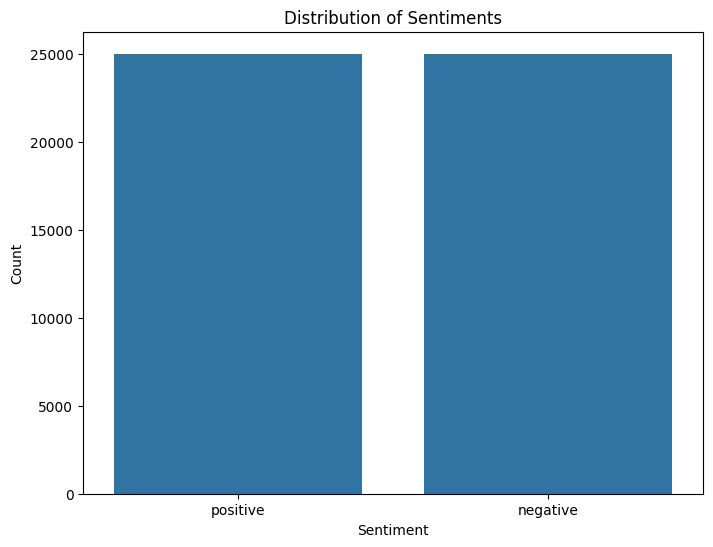

In [ ]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [ ]:
# 2. Data Preprocessing
print("\n2. Data Preprocessing")
print("-" * 50)

# Define preprocessing functions
def clean_text(text):
    """Clean and preprocess text data"""
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def remove_stopwords(text):
    """Remove stopwords from text"""
    try:
        # Try using NLTK stopwords
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(text)
        filtered_text = [word for word in word_tokens if word not in stop_words]
        return ' '.join(filtered_text)
    except LookupError:
        # Fallback to a basic list of stopwords if NLTK resources aren't available
        print("Using fallback stopwords list...")
        basic_stopwords = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
                          'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
                          'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them',
                          'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this',
                          'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
                          'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing',
                          'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
                          'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
                          'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to',
                          'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
                          'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
                          'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such',
                          'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very',
                          's', 't', 'can', 'will', 'just', 'don', 'should', 'now'}
        # Simple tokenization as fallback
        words = text.split()
        filtered_text = [word for word in words if word not in basic_stopwords]
        return ' '.join(filtered_text)

def lemmatize_text(text):
    """Lemmatize text"""
    try:
        # Try using NLTK WordNetLemmatizer
        lemmatizer = WordNetLemmatizer()
        word_tokens = word_tokenize(text)
        lemmatized_text = [lemmatizer.lemmatize(word) for word in word_tokens]
        return ' '.join(lemmatized_text)
    except LookupError:
        # Fallback to simple stemming-like functionality if NLTK resources aren't available
        print("Using fallback lemmatization approach...")
        # Simple function to remove common endings
        def simple_stem(word):
            if len(word) < 4:
                return word

            # Remove some common suffixes
            suffixes = ['ing', 'ed', 'ly', 's', 'es']
            for suffix in suffixes:
                if word.endswith(suffix) and len(word) - len(suffix) >= 3:
                    return word[:-len(suffix)]
            return word

        # Simple tokenization as fallback
        words = text.split()
        stemmed_words = [simple_stem(word) for word in words]
        return ' '.join(stemmed_words)


2. Data Preprocessing
--------------------------------------------------


In [ ]:
# Apply preprocessing steps
print("Cleaning text...")
df['cleaned_review'] = df['review'].apply(clean_text)

try:
    print("Removing stopwords...")
    df['cleaned_review'] = df['cleaned_review'].apply(remove_stopwords)

    print("Lemmatizing text...")
    df['cleaned_review'] = df['cleaned_review'].apply(lemmatize_text)
except Exception as e:
    print(f"Error during text preprocessing: {e}")
    print("Applying minimal preprocessing instead...")
    # Minimal preprocessing fallback
    df['cleaned_review'] = df['review'].apply(lambda x: x.lower())
    df['cleaned_review'] = df['cleaned_review'].apply(lambda x: re.sub(r'<.*?>', '', x))
    df['cleaned_review'] = df['cleaned_review'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x))
    df['cleaned_review'] = df['cleaned_review'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    df['cleaned_review'] = df['cleaned_review'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())


Streaming output truncated to the last 5000 lines.
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using 

In [ ]:
print("\nFirst 5 rows after preprocessing:")
print(df[['review', 'cleaned_review', 'sentiment']].head())

# Check for and handle missing values
print(f"\nMissing values before handling:\n{df.isnull().sum()}")
df = df.dropna()
print(f"Missing values after handling:\n{df.isnull().sum()}")


First 5 rows after preprocessing:
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review sentiment  
0  one reviewer mention watch 1 oz episode youll ...  positive  
1  wonderful little production film technique una...  positive  
2  thought wonderful way spend time hot summer we...  positive  
3  basical there fami little boy jake think there...  negative  
4  petter mattei love time money visual stunn fil...  positive  

Missing values before handling:
review            0
sentiment         0
cleaned_review    0
dtype: int64
Missing values after handling:
review            0
sentiment         0
cleaned_review    0
dtype: int64



3. Text Feature Visualization
--------------------------------------------------


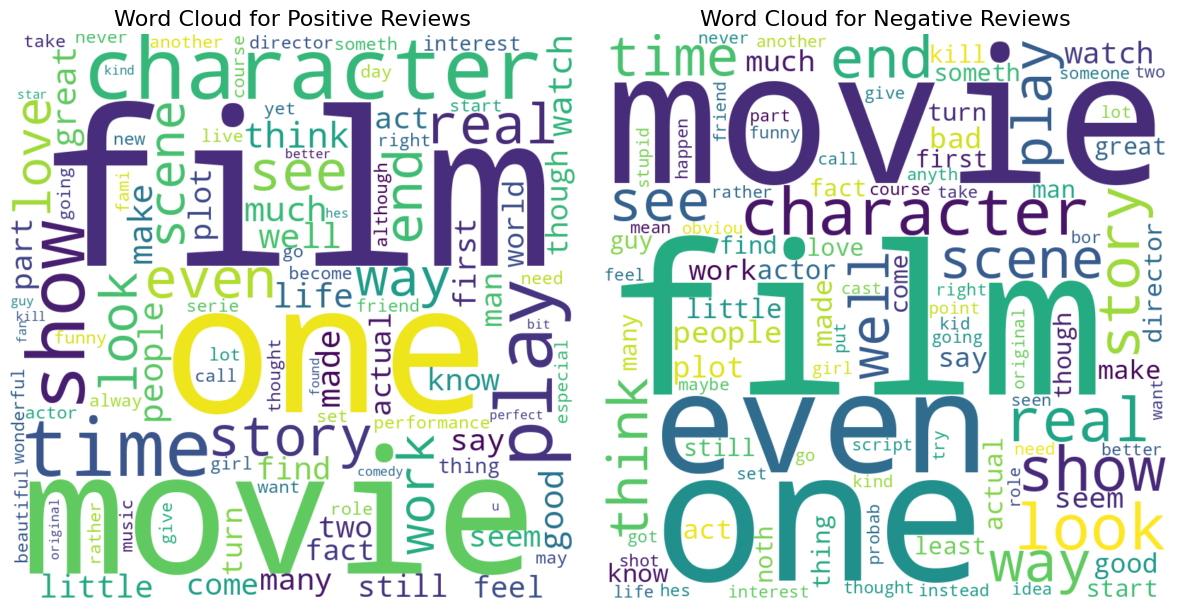

In [ ]:
# 3. Text Feature Visualization
print("\n3. Text Feature Visualization")
print("-" * 50)

# Generate word clouds for positive and negative reviews
try:
    plt.figure(figsize=(12, 6))

    # Positive reviews word cloud
    positive_reviews = df[df['sentiment'] == 'positive']['cleaned_review']
    positive_text = ' '.join(positive_reviews)

    plt.subplot(1, 2, 1)
    wordcloud_positive = WordCloud(width=800, height=800,
                                  background_color='white',
                                  max_words=100,
                                  contour_width=3,
                                  contour_color='steelblue').generate(positive_text)
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.title('Word Cloud for Positive Reviews', fontsize=16)
    plt.axis('off')

    # Negative reviews word cloud
    negative_reviews = df[df['sentiment'] == 'negative']['cleaned_review']
    negative_text = ' '.join(negative_reviews)

    plt.subplot(1, 2, 2)
    wordcloud_negative = WordCloud(width=800, height=800,
                                  background_color='white',
                                  max_words=100,
                                  contour_width=3,
                                  contour_color='firebrick').generate(negative_text)
    plt.imshow(wordcloud_negative, interpolation='bilinear')
    plt.title('Word Cloud for Negative Reviews', fontsize=16)
    plt.axis('off')

    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error generating word clouds: {e}")
    print("Skipping word cloud visualization and continuing with the analysis...")


In [ ]:
# 4. Data Preparation for Modeling
print("\n4. Data Preparation for Modeling")
print("-" * 50)

# Convert sentiment labels to numeric values
df['sentiment_numeric'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Split the data into training and testing sets
X = df['cleaned_review']
y = df['sentiment_numeric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


4. Data Preparation for Modeling
--------------------------------------------------
Training set size: 40000
Testing set size: 10000


In [ ]:
# 5. TF-IDF Vectorization and Model Building
print("\n5. TF-IDF Vectorization and Model Building")
print("-" * 50)

# Create a pipeline with TF-IDF vectorization and logistic regression
tfidf_params = {
    'max_features': 5000,
    'min_df': 5,
    'max_df': 0.7,
    'ngram_range': (1, 2)
}

lr_params = {
    'C': 1.0,
    'max_iter': 1000,
    'solver': 'liblinear',
    'random_state': 42
}

# Create the pipeline
print("Building the TF-IDF and Logistic Regression pipeline...")
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_params)),
    ('classifier', LogisticRegression(**lr_params))
])

# Train the model
print("Training the model...")
pipeline.fit(X_train, y_train)

# Make predictions
print("Making predictions on the test set...")
y_pred = pipeline.predict(X_test)


5. TF-IDF Vectorization and Model Building
--------------------------------------------------
Building the TF-IDF and Logistic Regression pipeline...
Training the model...
Making predictions on the test set...


In [ ]:
# 6. Model Evaluation
print("\n6. Model Evaluation")
print("-" * 50)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


6. Model Evaluation
--------------------------------------------------
Accuracy: 0.8911

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5000
           1       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



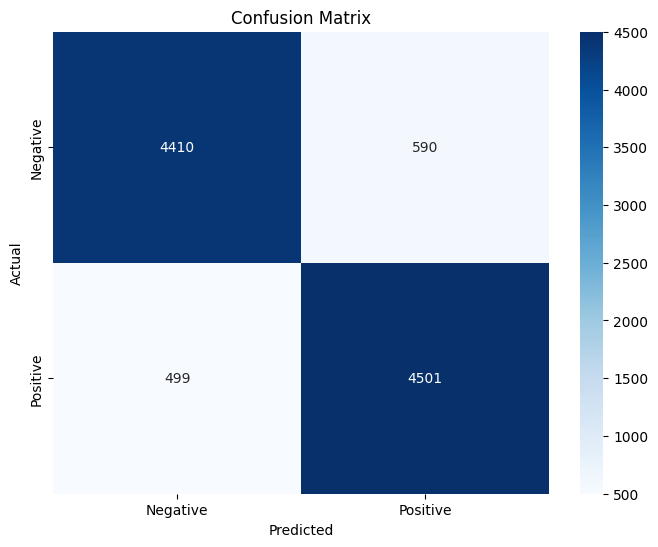

In [ ]:
# Generate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# 7. Feature Importance Analysis
print("\n7. Feature Importance Analysis")
print("-" * 50)

# Get the TF-IDF vectorizer and classifier from the pipeline
tfidf_vectorizer = pipeline.named_steps['tfidf']
classifier = pipeline.named_steps['classifier']

# Get feature names and coefficients
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = classifier.coef_[0]

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})


7. Feature Importance Analysis
--------------------------------------------------


In [ ]:
# Sort by absolute coefficient value
feature_importance['abs_coefficient'] = feature_importance['coefficient'].abs()
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

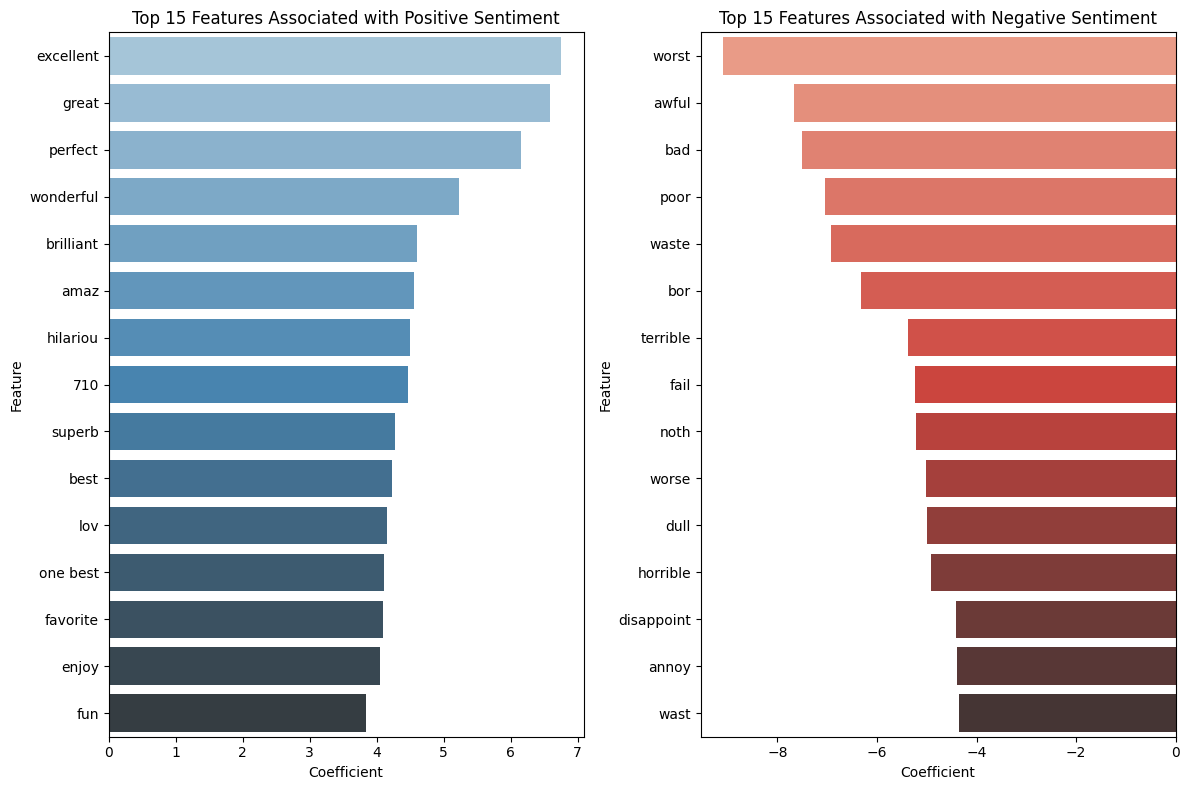

In [ ]:
# Plot top positive and negative coefficients
plt.figure(figsize=(12, 8))

# Top positive coefficients (features associated with positive sentiment)
plt.subplot(1, 2, 1)
top_positive = feature_importance[feature_importance['coefficient'] > 0].head(15)
sns.barplot(x='coefficient', y='feature', data=top_positive, palette='Blues_d')
plt.title('Top 15 Features Associated with Positive Sentiment')
plt.xlabel('Coefficient')
plt.ylabel('Feature')

# Top negative coefficients (features associated with negative sentiment)
plt.subplot(1, 2, 2)
top_negative = feature_importance[feature_importance['coefficient'] < 0].head(15)
sns.barplot(x='coefficient', y='feature', data=top_negative, palette='Reds_d')
plt.title('Top 15 Features Associated with Negative Sentiment')
plt.xlabel('Coefficient')
plt.ylabel('Feature')

plt.tight_layout()
plt.show()

In [ ]:
# 8. Model Testing with Sample Reviews
print("\n8. Model Testing with Sample Reviews")
print("-" * 50)

# Define some sample reviews to test the model
sample_reviews = [
    "This movie is absolutely amazing! The acting was superb and the plot was engaging.",
    "I hated every minute of this film. Terrible acting and boring storyline.",
    "The movie was okay, not great but not terrible either.",
    "Stunning visuals but the plot was confusing and hard to follow.",
    "I fell asleep during this movie. Complete waste of time and money."
]

# Make predictions on sample reviews
print("Predicting sentiment for sample reviews...")
sample_cleaned = [clean_text(review) for review in sample_reviews]
sample_cleaned = [remove_stopwords(review) for review in sample_cleaned]
sample_cleaned = [lemmatize_text(review) for review in sample_cleaned]

sample_predictions = pipeline.predict(sample_cleaned)
sample_proba = pipeline.predict_proba(sample_cleaned)

# Create a DataFrame to display the results
sample_results = pd.DataFrame({
    'Review': sample_reviews,
    'Predicted Sentiment': ['Positive' if pred == 1 else 'Negative' for pred in sample_predictions],
    'Confidence': [max(prob) for prob in sample_proba]
})

print("\nSample Review Predictions:")
for i, row in sample_results.iterrows():
    print(f"\nReview: {row['Review']}")
    print(f"Predicted Sentiment: {row['Predicted Sentiment']}")
    print(f"Confidence: {row['Confidence']:.4f}")



8. Model Testing with Sample Reviews
--------------------------------------------------
Predicting sentiment for sample reviews...
Using fallback stopwords list...
Using fallback stopwords list...
Using fallback stopwords list...
Using fallback stopwords list...
Using fallback stopwords list...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...
Using fallback lemmatization approach...

Sample Review Predictions:

Review: This movie is absolutely amazing! The acting was superb and the plot was engaging.
Predicted Sentiment: Positive
Confidence: 0.9201

Review: I hated every minute of this film. Terrible acting and boring storyline.
Predicted Sentiment: Negative
Confidence: 0.9926

Review: The movie was okay, not great but not terrible either.
Predicted Sentiment: Negative
Confidence: 0.9531

Review: Stunning visuals but the plot was confusing and hard to follow.
Predicted Se